In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import copy
from torch.utils.data import DataLoader,  TensorDataset
from sklearn.utils import shuffle
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import data_challenge_library as dcl
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelBinarizer

In [9]:
object_table = dcl.load_table(have_images = True)
object_table, validation_table = train_test_split(object_table, test_size = 0.1, random_state= 2121805)

table has 446487 sources
class
Gal         246225
Star         96715
Qso          83130
Agn           5608
highZQso      1089
Name: count, dtype: int64
Keeping 432767 labeled sources
Keeping 142963 with all features used in Savic+23
Keeping 142963 with available cutouts


In [10]:
X = object_table.drop(columns=["class", "label"])
y = object_table["label"].to_numpy().astype('int32')
objectID = object_table.index
X, y, objectID = shuffle(X, y, objectID, random_state = 2605)

X_validation = validation_table.drop(columns=["class", "label"])
y_validation = validation_table["label"].to_numpy().astype('int32')
objectID_validation = validation_table.index

In [11]:
X_train, X_test, y_train, y_test, objectID_train, objectID_test = train_test_split(X, y, 
                                objectID, test_size = 0.5, random_state = 1406)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)
display(X_train.shape, X_test.shape)

(64333, 62)

(64333, 62)

## ML Classifiers

In [6]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
print("Done with Random Forest")

catb =CatBoostClassifier()
catb.fit(X_train, y_train)
catb_predictions = catb.predict(X_test)
print("Done with Catboost")

abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
abc_predictions = abc.predict(X_test)
print("Done with Adaboost")

bgc = BaggingClassifier()
bgc.fit(X_train, y_train)
bgc_predictions = bgc.predict(X_test)
print("Done with Bagging")


Done with Random Forest
Learning rate set to 0.097848
0:	learn: 0.9318844	total: 72.1ms	remaining: 1m 12s
1:	learn: 0.8073226	total: 89.2ms	remaining: 44.5s
2:	learn: 0.7077433	total: 106ms	remaining: 35.1s
3:	learn: 0.6268308	total: 121ms	remaining: 30.1s
4:	learn: 0.5598617	total: 134ms	remaining: 26.7s
5:	learn: 0.5023189	total: 147ms	remaining: 24.4s
6:	learn: 0.4535600	total: 160ms	remaining: 22.7s
7:	learn: 0.4113863	total: 172ms	remaining: 21.4s
8:	learn: 0.3748038	total: 184ms	remaining: 20.3s
9:	learn: 0.3429484	total: 197ms	remaining: 19.5s
10:	learn: 0.3153463	total: 208ms	remaining: 18.7s
11:	learn: 0.2907485	total: 220ms	remaining: 18.1s
12:	learn: 0.2688543	total: 233ms	remaining: 17.7s
13:	learn: 0.2498117	total: 244ms	remaining: 17.2s
14:	learn: 0.2321573	total: 256ms	remaining: 16.8s
15:	learn: 0.2175315	total: 270ms	remaining: 16.6s
16:	learn: 0.2038704	total: 281ms	remaining: 16.2s
17:	learn: 0.1916743	total: 292ms	remaining: 15.9s
18:	learn: 0.1804556	total: 304ms	r

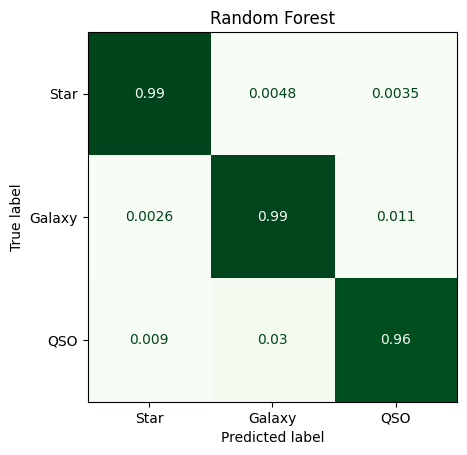

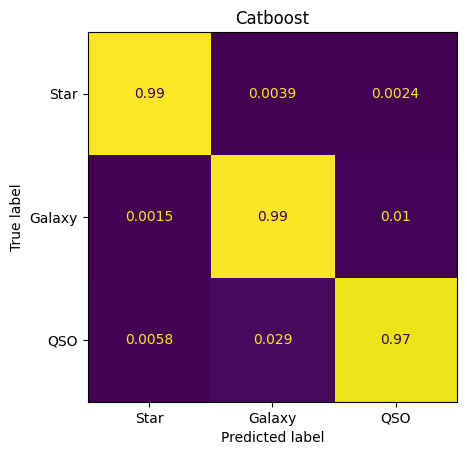

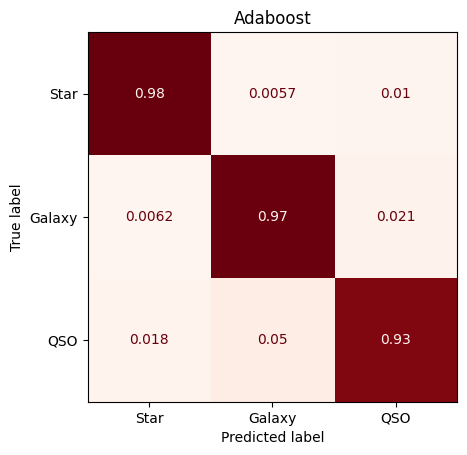

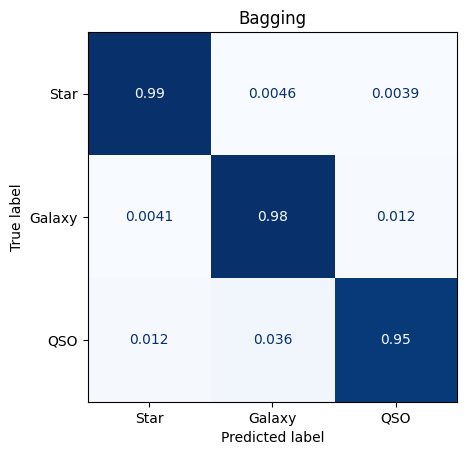

In [7]:
str_labels = ["Star", "Galaxy", "QSO"]
predictions =[rfc_predictions, catb_predictions, abc_predictions,
                   bgc_predictions]
names = ["Random Forest", "Catboost", "Adaboost", "Bagging"]
colors =[mpl.cm.Greens, mpl.cm.viridis, mpl.cm.Reds, mpl.cm.Blues]


for i, (prediction, name, color) in enumerate(zip(predictions, names, colors)):
    cf = confusion_matrix(y_test, prediction, normalize = "true")
    cm_display = ConfusionMatrixDisplay(cf, display_labels=str_labels);
    fig, ax = plt.subplots()
    cm_display.plot(ax=ax, cmap = color, colorbar = False)
    ax.set_title(name)
    plt.savefig(f"plots_angelica/cf_{name}.png", bbox_inches = "tight")

    



In [12]:
###Define a general Dense Neural network
class general_MLP(nn.Module):
    def __init__(self, input_size, output_size, N_hidden = 0, hidden_sizes =[],
                activation_function = nn.LeakyReLU, seed = 26052013, bias = True):
        super(general_MLP, self).__init__()
        assert len(hidden_sizes) == N_hidden
        self.seed = seed
        self.activation_function = activation_function
        
        if N_hidden == 0:
            self.full_sequence = nn.Sequential(nn.Linear(input_size, output_size, bias = bias),
                                               self.activation_function())

        elif N_hidden  == 1:
            assert len(hidden_sizes) == N_hidden
            first_layer_out = hidden_sizes[0]
            self.full_sequence = nn.Sequential(nn.Linear(input_size, hidden_sizes[0], bias = bias),
                                               self.activation_function(),
                                               nn.Linear(hidden_sizes[0],output_size, bias = bias),
                                               self.activation_function())
        else:
            first_layer_out = hidden_sizes[0]
            last_layer_in = hidden_sizes[-1]
        
            first_layer = [nn.Linear(input_size, first_layer_out, bias = bias),
                                self.activation_function()]
        
            hidden_layers =[]
            for N_in, N_out in zip(hidden_sizes[:-1],hidden_sizes[1:]):
                hidden_layers.append(nn.Linear(N_in, N_out, bias = bias))
                hidden_layers.append(self.activation_function())
            
            hidden_layers = hidden_layers

            last_layer = [nn.Linear(last_layer_in, output_size, bias = bias),
                                            self.activation_function()]
            

            self.full_sequence = nn.Sequential(*first_layer, *hidden_layers, *last_layer)
        
        
    def forward(self, x):
        x = self.full_sequence(x)
        return x

In [13]:
class general_convo2d(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 5, 
                 apply_convolution = True,
                 conv_kernel = 3, conv_stride = 1, conv_padding = 0,
                 pool_kernel = 1, pool_stride = 1, image_width = 16, 
                 activation_function = nn.LeakyReLU, seed = 24051941,  ):
        super(general_convo2d, self).__init__()
        
        self.seed = seed
        self.activation_function = activation_function
        if apply_convolution:
            self.model = nn.Sequential(nn.Conv2d(in_channels= in_channels, out_channels=out_channels,
                                    kernel_size = conv_kernel, stride = conv_stride, padding=conv_padding),
                                    self.activation_function(),
                                    nn.MaxPool2d(kernel_size=pool_kernel, stride = pool_stride))
        else: 
            self.model = nn.MaxPool2d(kernel_size=pool_kernel, stride = pool_stride)
        
        self.Nout_conv = np.floor((image_width+ 2*conv_padding - conv_kernel)/conv_stride) +1
        self.Nout_pool = np.floor((self.Nout_conv-pool_kernel)/pool_stride) +1
        self.Nout_tot = int(self.Nout_pool*self.Nout_pool*out_channels)
    
    def forward(self, image):
        image = self.model(image)
        return image
        
        

In [14]:
class merged_model(nn.Module):
    def __init__(self, process_tabular, process_image, process_flattened_image, process_both):
        super(merged_model, self).__init__()

        self.process_tabular = process_tabular
        self.process_image = process_image
        self.process_flattened_image = process_flattened_image
        self.process_both = process_both

    def forward(self, image, tabular):
        image = self.process_image(image)
        image = torch.flatten(image, start_dim = 1, end_dim = -1)
        image = self.process_flattened_image(image)    
        tabular = self.process_tabular(tabular)
        
        out = torch.concat([image, tabular], dim =1)
        out = self.process_both(out)    
        return out


In [15]:
def train_routine(dataloader, model, loss_fn, optimizer, verbose = True):
    losses = []
    num_batches = len(dataloader)
    for batch, (images, features, labels) in enumerate(dataloader): 
        output = model(images, features)
        loss = loss_fn(output, labels)

        # Backpropagation
        optimizer.zero_grad()    # Clear the gradient
        loss.backward()          # Compute the gradient (??)
        optimizer.step()         # update model weights

        
        if batch == round(num_batches/2):
            losses.append(loss.item())
            if verbose:
                print(f"loss: {loss:>7f}")

    return losses

def test_routine(dataloader, model, loss_fn, verbose = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    model.eval() 
    with torch.no_grad():
        for images, features, labels in dataloader:
            output = model(images, features)
            test_loss += loss_fn(output, labels).item()

    test_loss /= num_batches
    if verbose:
        print(f" Avg test loss      : {test_loss:>8f}")

    return test_loss

In [16]:
X_train_t, y_train_t = dcl.transform2tensor(X_train, y_train)
X_test_t, y_test_t = dcl.transform2tensor(X_test, y_test)

In [17]:
image_train = dcl.load_images(objectID_train, as_tensor = True)
image_test = dcl.load_images(objectID_test, as_tensor = True)

In [18]:
batch_size = 40
train_dataset = TensorDataset(image_train, X_train_t,  y_train_t)
test_dataset = TensorDataset(image_test, X_test_t, y_test_t)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True)

In [19]:
process_tabular = general_MLP(input_size = 62, output_size = 30, N_hidden = 1, hidden_sizes =[62],
                  activation_function = nn.LeakyReLU)
process_image = general_convo2d(out_channels = 1, conv_kernel = 1, conv_stride = 1, conv_padding = 0,
                             pool_kernel = 2, apply_convolution = True)
process_flattened_image = general_MLP(input_size = process_image.Nout_tot, output_size = 30, 
                                                   N_hidden = 1, hidden_sizes =[30])
process_both = general_MLP(input_size = 60, output_size = 3, N_hidden = 1, hidden_sizes =[30])


combined_model = merged_model(process_tabular, process_image, process_flattened_image, process_both)

In [20]:
EPOCHS = 20
SEED = 12
loss_fn = torch.nn.CrossEntropyLoss()  #torch.nn.CrossEntropyLoss
optimizer = torch.optim.SGD(combined_model.parameters(), lr=0.001, weight_decay=0.05)

In [21]:
train_loss = []
test_loss  = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}---------------------")
    train_loss.append(train_routine(train_dataloader, combined_model, loss_fn, optimizer, verbose = False))
    test_loss.append(test_routine(test_dataloader, combined_model, loss_fn, verbose = True))
print("Done!")

Epoch 1---------------------
 Avg test loss      : 1.080134
Epoch 2---------------------
 Avg test loss      : 1.053276
Epoch 3---------------------
 Avg test loss      : 0.957571
Epoch 4---------------------
 Avg test loss      : 0.771392
Epoch 5---------------------
 Avg test loss      : 0.728867
Epoch 6---------------------
 Avg test loss      : 0.717875
Epoch 7---------------------
 Avg test loss      : 0.712760
Epoch 8---------------------
 Avg test loss      : 0.710198
Epoch 9---------------------
 Avg test loss      : 0.708460
Epoch 10---------------------
 Avg test loss      : 0.707441
Epoch 11---------------------
 Avg test loss      : 0.706669
Epoch 12---------------------
 Avg test loss      : 0.706197
Epoch 13---------------------
 Avg test loss      : 0.705617
Epoch 14---------------------
 Avg test loss      : 0.705211
Epoch 15---------------------
 Avg test loss      : 0.704927
Epoch 16---------------------
 Avg test loss      : 0.704791
Epoch 17---------------------
 Av

NameError: name 'EPOCHS' is not defined

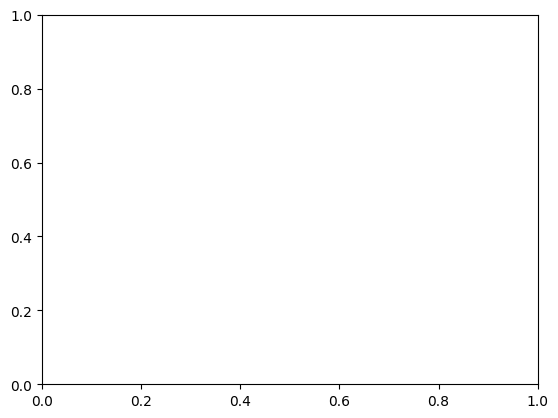

In [7]:
fig, ax = plt.subplots()
ax.plot(np.arange(EPOCHS), train_loss, label ='Train')
ax.plot(np.arange(EPOCHS), test_loss, label ='Test')
ax.set_xlabel("EPOCH")
ax.set_ylabel("Loss")
ax.legend()
plt.savefig("plots_angelica/Loss_function.png")

In [117]:
softmax = nn.Softmax(dim =1)
NN_probabilities = combined_model(image_test, X_test_t)
NN_probabilities = softmax(NN_probabilities.detach()).numpy()
NN_predictions = np.argmax(NN_probabilities, axis =1)

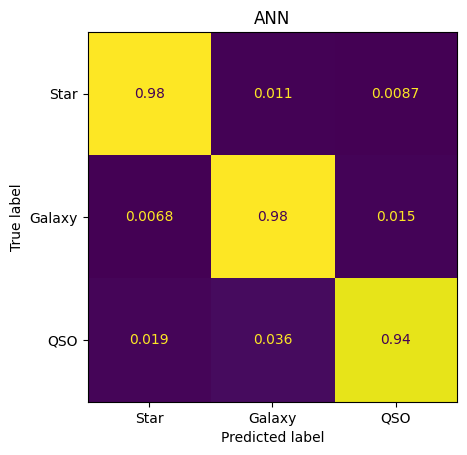

In [118]:
cf = confusion_matrix(y_test, NN_predictions, normalize ='true')
cm_display = ConfusionMatrixDisplay(cf, display_labels=str_labels);
fig, ax = plt.subplots()
cm_display.plot(ax=ax, cmap = mpl.cm.viridis,  colorbar = False)
ax.set_title("ANN")
plt.savefig(f"plots_angelica/cf_NN.png", bbox_inches = "tight")


In [120]:
import utility_library as ulb

In [121]:
def cross_entropy(predictions, targets, epsilon=1e-8):
    """Compute cross entropy given predictions as class probabilities and one-
    hot encoded ground truth labels.
    Parameters
    ----------
    predictions: np.array
        (num examples, num_classes) of predicted class probabilities
    targets: np.array
        (num examples, num_classes) of one-hot encoded true class labels
    epsilon: float
     a constant to clip predicted probabilities to avoid taking log of zero
    Returns
    -------
    cross_entropy: float
        cross entropy of the inputs
    """
    predictions = np.clip(predictions, epsilon, 1-epsilon)
    return (-np.log(predictions) * targets).sum(axis=1).mean()


def get_accuracy(predictions, targets, one_hot_targets=True):
    """Compute accuracy given arrays of predictions and targets.

    Parameters
    predictions: np.array
        (num examples, num_classes) of predicted class probabilities/scores
    targets: np.array
        (num examples, num_classes) of one hot encoded true class labels if
        'one_hot_targets' is True, or true class indices if it is False
    one_hot_targets: bool
        whether the target are in one-hot or class index format. Default is
        True

    Returns
    -------
    accuracy: float
        accuracy of predictions

    """
    if one_hot_targets:
        return (predictions.argmax(axis=1) == targets.argmax(axis=1)).mean()
    else:
        return (predictions.argmax(axis=1) == targets).mean()


In [122]:
rfc_probabilities = rfc.predict_proba(X_test)
catb_probabilities = catb.predict_proba(X_test)
abc_probabilities = abc.predict_proba(X_test)
bgc_probabilities = bgc.predict_proba(X_test)

In [140]:
enc = LabelBinarizer()


y_hats = {"Random Forest": rfc_probabilities,
          "Catboost"    : catb_probabilities,
          "Adaboost"    : abc_probabilities,
          "Bagging"     : bgc_probabilities,
          "Nnetwork"    : NN_probabilities}

#y_hats = {"Random Forest": enc.fit_transform(rfc_predictions),
#          "Catboost"    : enc.fit_transform(catb_predictions),
#          "Adaboost"    : enc.fit_transform(abc_predictions),
#          "Bagging"     : enc.fit_transform(bgc_predictions),
#           "Nnetwork"   : enc.fit_transform(NN_predictions)}




In [141]:
max_iter = 100
enc = LabelBinarizer()

ensemble_loss, model_weights = ulb.ensemble_selector(loss_function= cross_entropy, 
                                                     y_hats = y_hats,
                                                     y_true=enc.fit_transform(y_test), init_size=1, 
                                                    replacement=True, max_iter=100)


In [142]:
model_weights


,Random Forest,Catboost,Adaboost,Bagging,Nnetwork
0,0.000000,1.000000,0.0,0.000000,0.0
1,0.000000,1.000000,0.0,0.000000,0.0
2,0.000000,1.000000,0.0,0.000000,0.0
3,0.000000,1.000000,0.0,0.000000,0.0
4,0.000000,1.000000,0.0,0.000000,0.0
...,...,...,...,...,...
96,0.010309,0.979381,0.0,0.010309,0.0
97,0.010204,0.979592,0.0,0.010204,0.0
98,0.010101,0.979798,0.0,0.010101,0.0
99,0.010000,0.980000,0.0,0.010000,0.0


In [143]:
def voting_predictions(*probabilities, weights = "equal", vote = "soft", Nclasses=3):

    """"""
    if weights=="equal":
        weights = [1 for i in probabilities]
    else: assert(len(weights) == len(probabilities))

    weights = np.array(weights)/np.sum(weights)

    N_sources = probabilities[0].shape[0]
    
    if vote == "hard":
        predictions = np.zeros((N_sources, len(probabilities)), dtype=int)
        for i, probability in enumerate(probabilities):
            predictions[:,i] = np.argmax(probability, axis = 1)
            Nvotes = np.array([np.sum(predictions==i, axis = 1) for i in range(Nclasses)]).T
            final_predictions =   np.argmax(Nvotes, axis = 1)
    elif vote == "soft":
        weighted_probabilities = np.zeros((N_sources, Nclasses, len(probabilities)))
        for (i,probability)in enumerate(probabilities):
            weighted_probabilities[:,:,i] = weights[i]*probability
        final_predictions = np.argmax(np.sum(weighted_probabilities, axis = -1), axis = 1)        
    return final_predictions

In [144]:
probabilities = (rfc_probabilities, catb_probabilities,abc_probabilities,
                 bgc_probabilities, NN_probabilities)




ensemble_results = voting_predictions(*probabilities, weights =model_weights.iloc[max_iter,:].to_numpy())

/tmp/ipykernel_189464/298622754.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights=="equal":


[0.9937554  0.98824265 0.96567244]


All weighted classifiers provided 0.9852019958652636 overall as accuracy


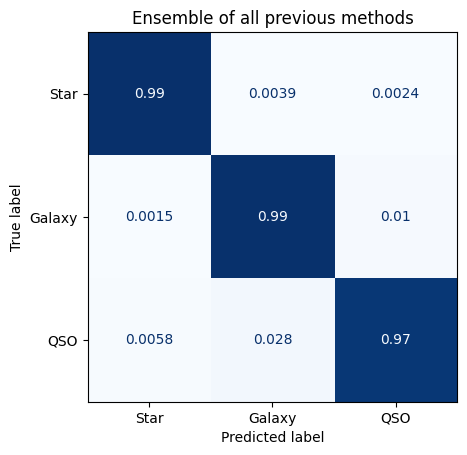

In [147]:
cf = confusion_matrix(y_test, ensemble_results, normalize = "true")
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(f"All weighted classifiers provided {accuracy_score(y_test, ensemble_results)} overall as accuracy")
cm_display = ConfusionMatrixDisplay(cf, display_labels=str_labels);
fig, ax = plt.subplots()
cm_display.plot(ax=ax, cmap = mpl.cm.Blues,  colorbar = False)
ax.set_title("Ensemble of all previous methods")
plt.savefig("plots_angelica/cf_ensemble.png", bbox_inches = "tight")

In [2]:
0.978/(0.002+0.021+0.978)

0.9770229770229771

[0.99371613 0.98824265 0.96560527]
All Catboost provided 0.985170907621283 overall as accuracy


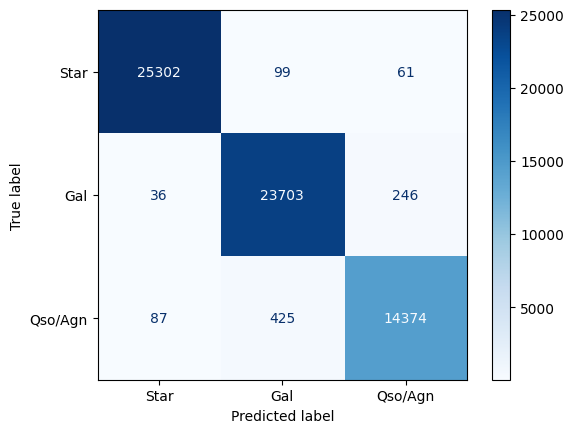

In [45]:
cf = confusion_matrix(y_test, catb_predictions)
str_labels = ['Star', 'Gal', 'Qso/Agn']
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(f"All Catboost provided {accuracy_score(y_test, catb_predictions)} overall as accuracy")
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot(cmap=mpl.cm.Blues);

In [39]:
ensemble_results

array([ 7025,     8,     8, 14613, 35912])

In [45]:
?LabelBinarizer

Init signature: LabelBinarizer(*, neg_label=0, pos_label=1, sparse_output=False)
Docstring:     
Binarize labels in a one-vs-all fashion.

Several regression and binary classification algorithms are
available in scikit-learn. A simple way to extend these algorithms
to the multi-class classification case is to use the so-called
one-vs-all scheme.

At learning time, this simply consists in learning one regressor
or binary classifier per class. In doing so, one needs to convert
multi-class labels to binary labels (belong or does not belong
to the class). LabelBinarizer makes this process easy with the
transform method.

At prediction time, one assigns the class for which the corresponding
model gave the greatest confidence. LabelBinarizer makes this easy
with the inverse_transform method.

Read more in the :ref:`User Guide <preprocessing_targets>`.

Parameters
----------
neg_label : int, default=0
    Value with which negative labels must be encoded.

pos_label : int, default=1
    Value 

In [12]:
?nn.Conv2d

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:

In [ ]:
rfc_probabilities = rfc.predict_proba(X_test)
catb_probabilities

In [18]:
m = nn.Softmax(3)

In [19]:
x = torch.randn(1,3)

In [27]:
m = nn.Softmax()
a = m(torch.tensor(NN_probabilities))

/tmp/ipykernel_2468925/3685596641.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = m(torch.tensor(NN_probabilities))


In [40]:
NN_probabilities

array([[0.94057494, 0.02787304, 0.03155199],
       [0.06853253, 0.07695886, 0.85450864],
       [0.32790458, 0.23702882, 0.4350666 ],
       ...,
       [0.05076876, 0.11307462, 0.8361566 ],
       [0.01803507, 0.9560674 , 0.02589751],
       [0.96048003, 0.01841687, 0.02110305]], dtype=float32)

In [ ]:
def ensemble_selector(loss_function, y_hats, y_true, init_size=1,
                      replacement=True, max_iter=100):
    
    """
    see https://towardsdatascience.com/ensembles-the-almost-free-lunch-in-machine-learning-91af7ebe5090
    Implementation of the algorithm of Caruana et al. (2004) 'Ensemble
    Selection from Libraries of Models'. Given a loss function mapping
    predicted and ground truth values to a scalar along with a dictionary of
    models with predicted and ground truth values, constructs an optimal
    ensemble minimizing ensemble loss, by default allowing models to appear
    several times in the ensemble.
    Parameters
    ----------
    loss_function: function
        accepting two arguments - numpy arrays of predictions and true values - 
        and returning a scalar
    y_hats: dict
        with keys being model names and values being numpy arrays of predicted
        values
    y_true: np.array
        numpy array of true values, same for each model
    init_size: int
        number of models in the initial ensemble, picked by the best loss.
        Default is 1
    replacement: bool
        whether the models should be returned back to the pool of models once
        added to the ensemble. Default is True
    max_iter: int
        number of iterations for selection with replacement to perform. Only
        relevant if 'replacement' is True, otherwise iterations continue until
        the dataset is exhausted i.e.
        min(len(y_hats.keys())-init_size, max_iter). Default is 100
    Returns
    -------
    ensemble_loss: pd.Series
        with loss of the ensemble over iterations
    model_weights: pd.DataFrame
        with model names across columns and ensemble selection iterations
        across rows. Each value is the weight of a model in the ensemble
    """
    # Step 1: compute losses
    losses = dict()
    for model, y_hat in y_hats.items():
        losses[model] = loss_function(y_hat, y_true)

    # Get the initial ensemble comprising the best models
    losses = pd.Series(losses).sort_values()
    init_ensemble = losses.iloc[:init_size].index.tolist()

    # Compute its loss
    if init_size == 1:
        # Take the best loss
        init_loss = losses.loc[init_ensemble].values[0]
        y_hat_avg = y_hats[init_ensemble[0]].copy()
    else:
        # Average the predictions over several models
        y_hat_avg = np.array(
            [y_hats[mod] for mod in init_ensemble]).mean(axis=0)
        init_loss = loss_function(y_hat_avg, y_true)

    # Define the set of available models
    if replacement:
        available_models = list(y_hats.keys())
    else:
        available_models = losses.index.difference(init_ensemble).tolist()
        # Redefine maximum number of iterations
        max_iter = min(len(available_models), max_iter)

    # Sift through the available models keeping track of the ensemble loss
    # Redefine variables for the clarity of exposition
    current_loss = init_loss
    current_size = init_size

    loss_progress = [current_loss]
    ensemble_members = [init_ensemble]
    for i in range(max_iter):
        # Compute weights for predictions
        w_current = current_size / (current_size + 1)
        w_new = 1 / (current_size + 1)

        # Try all models one by one
        tmp_losses = dict()
        tmp_y_avg = dict()
        for mod in available_models:
            tmp_y_avg[mod] = w_current * y_hat_avg + w_new * y_hats[mod]
            tmp_losses[mod] = loss_function(tmp_y_avg[mod], y_true)

        # Locate the best trial
        best_model = pd.Series(tmp_losses).sort_values().index[0]

        # Update the loop variables and record progress
        current_loss = tmp_losses[best_model]
        loss_progress.append(current_loss)
        y_hat_avg = tmp_y_avg[best_model]
        current_size += 1
        ensemble_members.append(ensemble_members[-1] + [best_model])

        if not replacement:
            available_models.remove(best_model)

    # Organize the output
    ensemble_loss = pd.Series(loss_progress, name="loss")
    model_weights = pd.DataFrame(index=ensemble_loss.index,
                                 columns=y_hats.keys())
    for ix, row in model_weights.iterrows():
        weights = pd.Series(ensemble_members[ix]).value_counts()
        weights = weights / weights.sum()
        model_weights.loc[ix, weights.index] = weights

    return ensemble_loss, model_weights.fillna(0).astype(float)


In [6]:
import pandas as pd
import numpy as np

In [39]:
y_hats = {'a': 0, 'b' : 0, 'c' : 2}

In [42]:
replacement = True
init_size = 1 
max_iter = 10
losses = dict()
for model, y_hat in y_hats.items():
        losses[model] = y_hat+np.random.randn()
losses = pd.Series(losses).sort_values()
init_ensemble = losses.iloc[:init_size].index.tolist()
init_loss = losses.loc[init_ensemble].values[0]
y_hat_avg = np.copy(y_hats[init_ensemble[0]])
if replacement:
    available_models = list(y_hats.keys())
else:
    available_models = losses.index.difference(init_ensemble).tolist()
        # Redefine maximum number of iterations
    max_iter = min(len(available_models), max_iter)

    # Sift through the available models keeping track of the ensemble loss
    # Redefine variables for the clarity of exposition
current_loss = init_loss
current_size = init_size
loss_progress = [current_loss]
ensemble_members = [init_ensemble]
for i in range(max_iter):
        # Compute weights for predictions
        w_current = current_size / (current_size + 1)
        w_new = 1 / (current_size + 1)

        # Try all models one by one
        tmp_losses = dict()
        tmp_y_avg = dict()
        for mod in available_models:
            tmp_y_avg[mod] = w_current * y_hat_avg + w_new * y_hats[mod]
            tmp_losses[mod] = tmp_y_avg[mod] + np.random.randn() 

        # Locate the best trial
        best_model = pd.Series(tmp_losses).sort_values().index[0]

        # Update the loop variables and record progress
        current_loss = tmp_losses[best_model]
        loss_progress.append(current_loss)
        y_hat_avg = tmp_y_avg[best_model]
        current_size += 1
        ensemble_members.append(ensemble_members[-1] + [best_model])

In [43]:
ensemble_members

[['b'],
 ['b', 'a'],
 ['b', 'a', 'b'],
 ['b', 'a', 'b', 'a'],
 ['b', 'a', 'b', 'a', 'a'],
 ['b', 'a', 'b', 'a', 'a', 'b'],
 ['b', 'a', 'b', 'a', 'a', 'b', 'c'],
 ['b', 'a', 'b', 'a', 'a', 'b', 'c', 'b'],
 ['b', 'a', 'b', 'a', 'a', 'b', 'c', 'b', 'a'],
 ['b', 'a', 'b', 'a', 'a', 'b', 'c', 'b', 'a', 'b'],
 ['b', 'a', 'b', 'a', 'a', 'b', 'c', 'b', 'a', 'b', 'b']]

In [44]:
ensemble_loss = pd.Series(loss_progress, name="loss")
model_weights = pd.DataFrame(index=ensemble_loss.index,
                                 columns=y_hats.keys())
for ix, row in model_weights.iterrows():
    weights = pd.Series(ensemble_members[ix]).value_counts()
    weights = weights / weights.sum()
    model_weights.loc[ix, weights.index] = weights


In [47]:
pd.Series(ensemble_members[3]).value_counts().index

Index(['b', 'a'], dtype='object')

In [ ]:
ensemble_loss = pd.Series(loss_progress, name="loss")
model_weights = pd.DataFrame(index=ensemble_loss.index,
                                 columns=y_hats.keys())

for ix, row in model_weights.iterrows():
    weights = pd.Series(ensemble_members[ix]).value_counts()
    weights = weights / weights.sum()
    model_weights.loc[ix, weights.index] = weights

    return ensemble_loss, model_weights.fillna(0).astype(float)

In [20]:
for i in range(max_iter):
        # Compute weights for predictions
        w_current = current_size / (current_size + 1)
        w_new = 1 / (current_size + 1)

        # Try all models one by one
        tmp_losses = dict()
        tmp_y_avg = dict()
        for mod in available_models:
            tmp_y_avg[mod] = w_current * y_hat_avg + w_new * y_hats[mod]
            tmp_losses[mod] = tmp_y_avg[mod] +1 

        # Locate the best trial
        best_model = pd.Series(tmp_losses).sort_values().index[0]

        # Update the loop variables and record progress
        current_loss = tmp_losses[best_model]
        loss_progress.append(current_loss)
        y_hat_avg = tmp_y_avg[best_model]
        current_size += 1
        ensemble_members.append(ensemble_members[-1] + [best_model])

0

In [ ]:
ensemble_loss = pd.Series(loss_progress, name="loss")
model_weights = pd.DataFrame(index=ensemble_loss.index,
                                 columns=y_hats.keys())

for ix, row in model_weights.iterrows():
    weights = pd.Series(ensemble_members[ix]).value_counts()
    weights = weights / weights.sum()
    model_weights.loc[ix, weights.index] = weights

    return ensemble_loss, model_weights.fillna(0).astype(float)

In [22]:
1/0.6

1.6666666666666667

In [23]:
1.6666666666666667*2.5

4.166666666666667

In [25]:
2.22*1.66

3.6852

In [ ]:
    # Define the set of available models
    if replacement:
        available_models = list(y_hats.keys())
    else:
        available_models = losses.index.difference(init_ensemble).tolist()
        # Redefine maximum number of iterations
        max_iter = min(len(available_models), max_iter)

    # Sift through the available models keeping track of the ensemble loss
    # Redefine variables for the clarity of exposition
    current_loss = init_loss
    current_size = init_size

    loss_progress = [current_loss]
    ensemble_members = [init_ensemble]

In [40]:
len([])

0